## MSDS458 Research Assignment 02 Experiments

Experiment 1: DNN with 2 layers (no regularization)

Experiment 2: DNN with 3 layers (no regularization)

Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

Experiment 5+ : You will conduct several more experiments. 
(a) Redo all the 4 experiments with some regularization technique. 
(b) Create more experiments on your own by tweaking architectures and/or hyper parameters.

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Import packages needed 

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


### Mount Google Drive to Colab Environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Functions for Research Assignment

In [6]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [9]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


### Review labels for training dataset

In [10]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


### Plot Examples

In [11]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [12]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [13]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

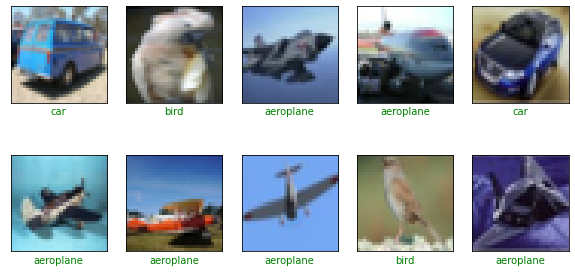

In [14]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

### Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [15]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

### Create Validation Data Set

In [16]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

### Confirm Datasets {Train, Validation, Test}

In [17]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


### Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [18]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


In [19]:
"""
#Build CNN Model
#We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning. The last 3 layers, handle classification
model = models.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))
"""

'\n#Build CNN Model\n#We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning. The last 3 layers, handle classification\nmodel = models.Sequential()\nmodel.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))\nmodel.add(layers.MaxPool2D((2, 2),strides=2))\nmodel.add(layers.Dropout(0.3))\nmodel.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))\nmodel.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))\nmodel.add(layers.Dropout(0.3))\nmodel.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))\nmodel.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))\nmodel.add(layers.Dropout(0.3))\nmodel.add(layers.Flatten())\nmodel.add(layers.BatchNormalization())\nmodel.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))\nmodel.add(layers.D

In [20]:
import datetime as dt

def compile_train_model(model):
  #compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model
  history = model.fit(x_train_norm
                      ,y_train_split
                      ,epochs=20
                      ,batch_size=100
                      ,validation_data=(x_valid_norm, y_valid_split)
                      ,callbacks=[
                      #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3), # remove early stop so that we can see if the model is able to overfit
                      tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                    )

  #evaluate model
  loss, accuracy = model.evaluate(x_test_norm, y_test)
  print('test set accuracy: ', accuracy * 100)

  #predict model
  preds = model.predict(x_test_norm)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime

  #loss and accuracy for training and validation data
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
  plt.show()  

  return result

In [21]:
import datetime as dt

def compile_train_plot_model(model):
  #plot model
  keras.utils.plot_model(model1, "CIFAR10.png", show_shapes=True) 

  #compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model
  history = model.fit(x_train_norm
                      ,y_train_split
                      ,epochs=20
                      ,batch_size=100
                      ,validation_data=(x_valid_norm, y_valid_split)
                      ,callbacks=[
                      #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                      tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                    )

  #evaluate model
  loss, accuracy = model.evaluate(x_test_norm, y_test)
  print('test set accuracy: ', accuracy * 100)

  #predict model
  preds = model.predict(x_test_norm)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime

  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  #loss and accuracy for training and validation data
  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
  plt.show()                        

  #confuison matrix
  pred1= model.predict(x_test_norm)
  pred1=np.argmax(pred1, axis=1)
  print_validation_report(y_test, pred1)
  plot_confusion_matrix(y_test,pred1)

  return result


### Experiment 1: DNN with 2 layers (no regularization)

In [22]:
model1 = models.Sequential()
model1.add(layers.InputLayer(input_shape=(32, 32, 3)))
model1.add(layers.Flatten(name ='flatten'))
model1.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu))
model1.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 hidden_layer (Dense)        (None, 384)               1180032   
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,183,882
Trainable params: 1,183,882
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
450/450 [==============================] - 5s 7ms/step - loss: 1.9874 - accuracy: 0.3033 - val_loss: 1.8380 - val_accuracy: 0.3434
Epoch 2/20
450/450 [==============================] - 1s 3ms/step - loss: 1.7718 - accuracy: 0.3742 - val_loss: 1.7718 - val_accuracy: 0.3784
Epoch 3/20
450/450 [==============================] - 2s 3ms/step - loss: 1.6979 - accuracy: 0.3986 - val_loss: 1.6959 - val_accuracy: 0.3918
Epoch 4/20
450/450 [==============================] - 2s 3ms/step - loss: 1.6568 - accuracy: 0.4120 - val_loss: 1.6494 - val_accuracy: 0.4106
Epoch 5/20
450/450 [==============================] - 2s 3ms/step - loss: 1.6203 - accuracy: 0.4230 - val_loss: 1.6465 - val_accuracy: 0.4074
Epoch 6/20
450/450 [==============================] - 2s 4ms/step - loss: 1.5901 - accuracy: 0.4342 - val_loss: 1.6352 - val_accuracy: 0.4140
Epoch 7/20
450/450 [==============================] - 2s 4ms/step - loss: 1.5689 - accuracy: 0.4413 - val_loss: 1.6281 - val_accuracy: 0.4204
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

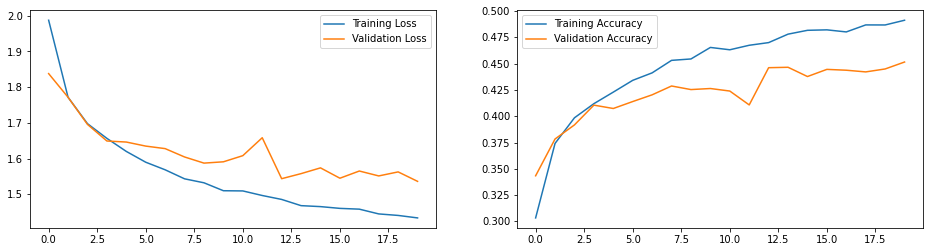

Classification Report
              precision    recall  f1-score   support

           0       0.46      0.59      0.52      1000
           1       0.54      0.61      0.57      1000
           2       0.34      0.31      0.32      1000
           3       0.35      0.31      0.33      1000
           4       0.40      0.40      0.40      1000
           5       0.44      0.28      0.35      1000
           6       0.45      0.63      0.53      1000
           7       0.52      0.47      0.49      1000
           8       0.58      0.58      0.58      1000
           9       0.57      0.49      0.53      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.46     10000
weighted avg       0.47      0.47      0.46     10000

Accuracy Score: 0.4673
Root Mean Square Error: 3.2636482653619403


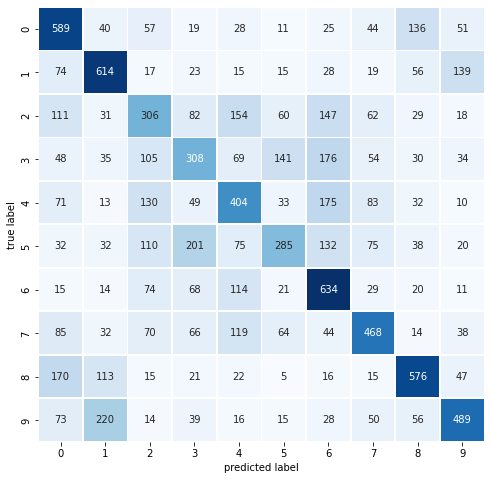

In [23]:
result1 = compile_train_plot_model(model1)

In [24]:
assignment_result_table = result1
new_col = ['DNN with 2 layers (no regularization)']   
assignment_result_table.insert(loc=0, column='Model', value=new_col)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time
19,DNN with 2 layers (no regularization),1.434201,0.491333,1.536505,0.4516,1.498227,0.4673,39.13391


## Experiment 2: DNN with 3 layers (no regularization)

In [25]:
model2 = models.Sequential()
model2.add(layers.InputLayer(input_shape=(32, 32, 3)))
model2.add(layers.Flatten(name ='flatten'))
model2.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu))
model2.add(layers.Dense(name = "hidden_layer2",units=384, activation=tf.nn.relu))
model2.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 hidden_layer (Dense)        (None, 384)               1180032   
                                                                 
 hidden_layer2 (Dense)       (None, 384)               147840    
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,331,722
Trainable params: 1,331,722
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
450/450 [==============================] - 2s 4ms/step - loss: 1.8731 - accuracy: 0.3268 - val_loss: 1.7342 - val_accuracy: 0.3680
Epoch 2/20
450/450 [==============================] - 2s 4ms/step - loss: 1.6745 - accuracy: 0.3996 - val_loss: 1.6524 - val_accuracy: 0.4134
Epoch 3/20
450/450 [==============================] - 2s 4ms/step - loss: 1.5946 - accuracy: 0.4335 - val_loss: 1.5856 - val_accuracy: 0.4330
Epoch 4/20
450/450 [==============================] - 2s 4ms/step - loss: 1.5325 - accuracy: 0.4542 - val_loss: 1.5455 - val_accuracy: 0.4480
Epoch 5/20
450/450 [==============================] - 2s 5ms/step - loss: 1.4941 - accuracy: 0.4683 - val_loss: 1.5044 - val_accuracy: 0.4596
Epoch 6/20
450/450 [==============================] - 2s 4ms/step - loss: 1.4535 - accuracy: 0.4810 - val_loss: 1.5402 - val_accuracy: 0.4472
Epoch 7/20
450/450 [==============================] - 2s 4ms/step - loss: 1.4192 - accuracy: 0.4944 - val_loss: 1.4754 - val_accuracy: 0.4784
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

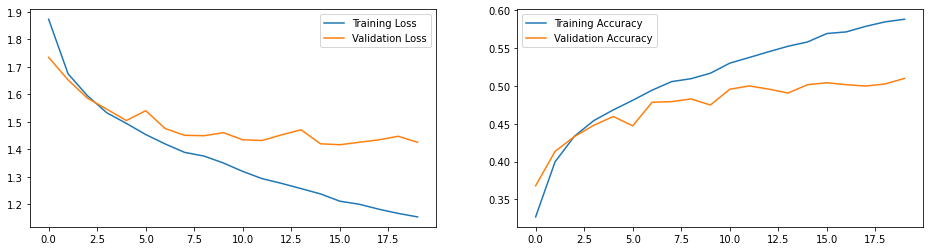

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.52      0.58      1000
           1       0.63      0.63      0.63      1000
           2       0.44      0.38      0.41      1000
           3       0.34      0.28      0.31      1000
           4       0.47      0.39      0.43      1000
           5       0.41      0.43      0.42      1000
           6       0.49      0.62      0.54      1000
           7       0.54      0.60      0.57      1000
           8       0.64      0.64      0.64      1000
           9       0.50      0.64      0.56      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000

Accuracy Score: 0.5123
Root Mean Square Error: 3.0380915061926625


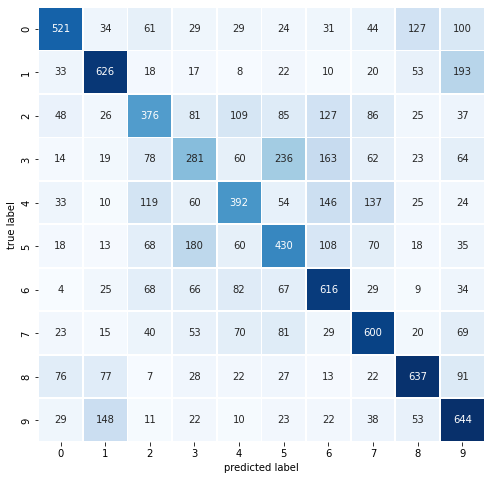

In [26]:
result2 = compile_train_plot_model(model2)

In [27]:
new_col = ['DNN with 3 layers (no regularization)']   
result2.insert(loc=0, column='Model', value=new_col)

assignment_result_table = assignment_result_table.append(result2, ignore_index = True)

assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time
0,DNN with 2 layers (no regularization),1.434201,0.491333,1.536505,0.4516,1.498227,0.4673,39.133910
1,DNN with 3 layers (no regularization),1.153715,0.588200,1.425242,0.5100,1.403160,0.5123,40.682541


## Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

In [28]:
model3 = models.Sequential()
model3.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model3.add(layers.MaxPool2D((2, 2),strides=2))
#model3.add(layers.Dropout(0.3))
model3.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model3.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
#model3.add(layers.Dropout(0.3))
model3.add(layers.Flatten())
model3.add(layers.BatchNormalization())
model3.add(layers.Dense(units=384, activation=tf.nn.relu))
model3.add(layers.Dense(units=10, activation=tf.nn.softmax))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 batch_normalization (BatchN  (None, 9216)            

Epoch 1/20
450/450 [==============================] - 15s 15ms/step - loss: 1.2169 - accuracy: 0.5759 - val_loss: 1.5314 - val_accuracy: 0.4248
Epoch 2/20
450/450 [==============================] - 6s 14ms/step - loss: 0.8280 - accuracy: 0.7098 - val_loss: 1.0698 - val_accuracy: 0.6440
Epoch 3/20
450/450 [==============================] - 7s 15ms/step - loss: 0.6370 - accuracy: 0.7792 - val_loss: 1.0987 - val_accuracy: 0.6600
Epoch 4/20
450/450 [==============================] - 8s 19ms/step - loss: 0.4695 - accuracy: 0.8358 - val_loss: 1.0712 - val_accuracy: 0.6836
Epoch 5/20
450/450 [==============================] - 6s 14ms/step - loss: 0.3296 - accuracy: 0.8857 - val_loss: 1.5870 - val_accuracy: 0.6142
Epoch 6/20
450/450 [==============================] - 6s 14ms/step - loss: 0.2264 - accuracy: 0.9250 - val_loss: 1.2456 - val_accuracy: 0.6800
Epoch 7/20
450/450 [==============================] - 6s 14ms/step - loss: 0.1636 - accuracy: 0.9470 - val_loss: 1.3137 - val_accuracy: 0.688

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

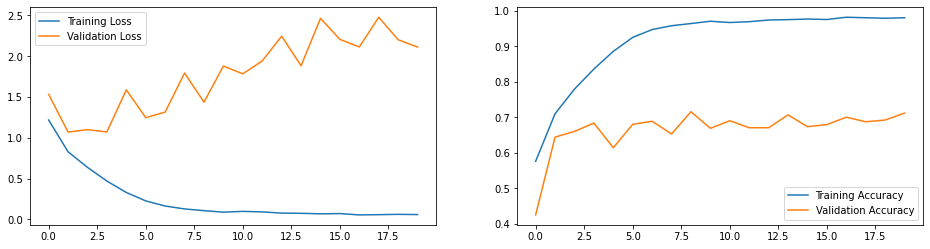

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      1000
           1       0.83      0.83      0.83      1000
           2       0.63      0.57      0.60      1000
           3       0.44      0.61      0.51      1000
           4       0.72      0.59      0.65      1000
           5       0.60      0.56      0.58      1000
           6       0.75      0.82      0.78      1000
           7       0.75      0.74      0.75      1000
           8       0.89      0.71      0.79      1000
           9       0.78      0.77      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000

Accuracy Score: 0.6988
Root Mean Square Error: 2.2617028982605123


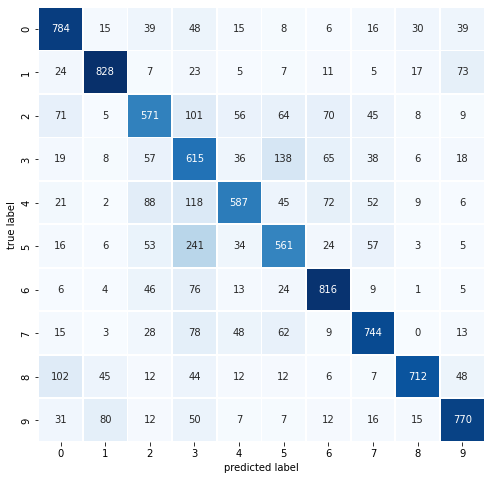

In [29]:
result3 = compile_train_plot_model(model3)

In [30]:
new_col = ['CNN with 2 convolution/max pooling layers (no regularization)']   
result3.insert(loc=0, column='Model', value=new_col)

assignment_result_table = assignment_result_table.append(result3, ignore_index = True)

assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time
0,DNN with 2 layers (no regularization),1.434201,0.491333,1.536505,0.4516,1.498227,0.4673,39.133910
1,DNN with 3 layers (no regularization),1.153715,0.588200,1.425242,0.5100,1.403160,0.5123,40.682541
2,CNN with 2 convolution/max pooling layers (no ...,0.058982,0.980289,2.110118,0.7116,2.168833,0.6988,142.778869


## Experiment 4: CNN with 3 convolution/max pooling layers (no regularization)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 512)       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

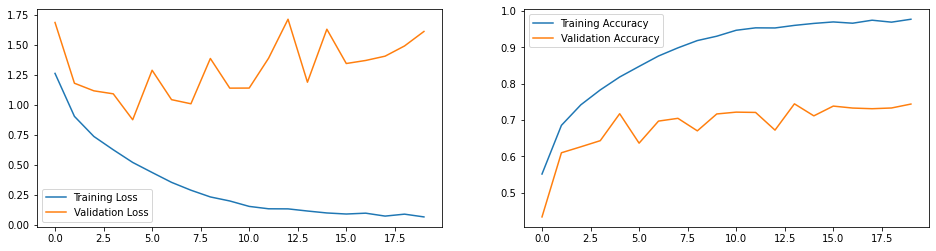

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1000
           1       0.83      0.85      0.84      1000
           2       0.54      0.73      0.62      1000
           3       0.67      0.44      0.53      1000
           4       0.72      0.69      0.70      1000
           5       0.70      0.59      0.64      1000
           6       0.77      0.84      0.80      1000
           7       0.81      0.74      0.77      1000
           8       0.84      0.82      0.83      1000
           9       0.79      0.83      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000

Accuracy Score: 0.7342
Root Mean Square Error: 2.1401869077255844


,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time
0,DNN with 2 layers (no regularization),1.434201,0.491333,1.536505,0.4516,1.498227,0.4673,39.133910
1,DNN with 3 layers (no regularization),1.153715,0.588200,1.425242,0.5100,1.403160,0.5123,40.682541
2,CNN with 2 convolution/max pooling layers (no ...,0.058982,0.980289,2.110118,0.7116,2.168833,0.6988,142.778869
3,CNN with 3 convolution/max pooling layers (no ...,0.065756,0.976956,1.609691,0.7440,1.675821,0.7342,150.401488


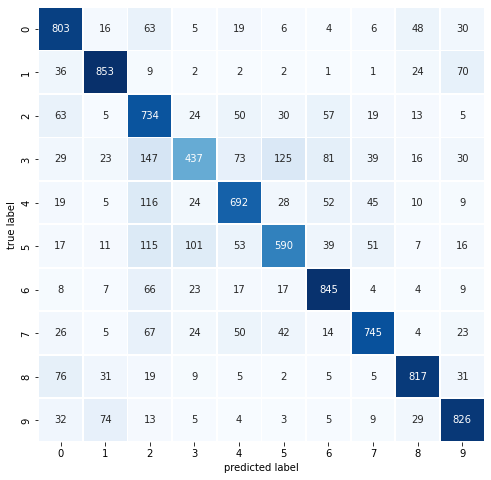

In [31]:
model4 = models.Sequential()
model4.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model4.add(layers.MaxPool2D((2, 2),strides=2))
#model4.add(layers.Dropout(0.3))
model4.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
#model4.add(layers.Dropout(0.3))
model4.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
#model4.add(layers.Dropout(0.3))
model4.add(layers.Flatten())
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(units=384, activation=tf.nn.relu))
model4.add(layers.Dense(units=10, activation=tf.nn.softmax))

model4.summary()

result4 = compile_train_plot_model(model4)

new_col = ['CNN with 3 convolution/max pooling layers (no regularization)']   
result4.insert(loc=0, column='Model', value=new_col)

assignment_result_table = assignment_result_table.append(result4, ignore_index = True)

assignment_result_table

## Experiment 5+ : You will conduct several more experiments. 

(a) Redo all the 4 experiments with some regularization technique. 


Epoch 1/20
450/450 [==============================] - 2s 4ms/step - loss: 2.3580 - accuracy: 0.2724 - val_loss: 2.0096 - val_accuracy: 0.3524
Epoch 2/20
450/450 [==============================] - 2s 4ms/step - loss: 1.9835 - accuracy: 0.3233 - val_loss: 1.8513 - val_accuracy: 0.3646
Epoch 3/20
450/450 [==============================] - 1s 3ms/step - loss: 1.9093 - accuracy: 0.3335 - val_loss: 1.8800 - val_accuracy: 0.3418
Epoch 4/20
450/450 [==============================] - 2s 4ms/step - loss: 1.8931 - accuracy: 0.3342 - val_loss: 1.8004 - val_accuracy: 0.3864
Epoch 5/20
450/450 [==============================] - 2s 3ms/step - loss: 1.8858 - accuracy: 0.3322 - val_loss: 1.8203 - val_accuracy: 0.3698
Epoch 6/20
450/450 [==============================] - 2s 4ms/step - loss: 1.8746 - accuracy: 0.3409 - val_loss: 1.7746 - val_accuracy: 0.3876
Epoch 7/20
450/450 [==============================] - 2s 3ms/step - loss: 1.8648 - accuracy: 0.3442 - val_loss: 1.8019 - val_accuracy: 0.3766
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

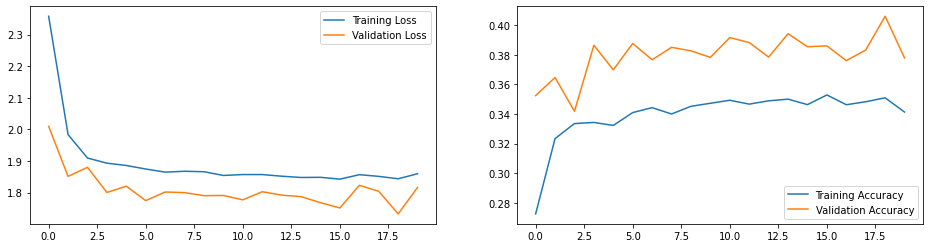

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time
0,DNN with 2 layers (no regularization),1.434201,0.491333,1.536505,0.4516,1.498227,0.4673,39.133910
1,DNN with 3 layers (no regularization),1.153715,0.588200,1.425242,0.5100,1.403160,0.5123,40.682541
2,CNN with 2 convolution/max pooling layers (no ...,0.058982,0.980289,2.110118,0.7116,2.168833,0.6988,142.778869
3,CNN with 3 convolution/max pooling layers (no ...,0.065756,0.976956,1.609691,0.7440,1.675821,0.7342,150.401488
4,DNN with 2 layers (with regularization),1.859747,0.341267,1.816639,0.3778,1.794182,0.3857,35.777248


In [32]:
model1_reg = models.Sequential()
model1_reg.add(layers.InputLayer(input_shape=(32, 32, 3)))
model1_reg.add(layers.Flatten(name ='flatten'))
model1_reg.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model1_reg.add(layers.Dropout(0.3))
model1_reg.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

result1_reg = compile_train_model(model1_reg)

new_col = ['DNN with 2 layers (with regularization)']   
result1_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result1_reg, ignore_index = True)
assignment_result_table

Epoch 1/20
450/450 [==============================] - 2s 4ms/step - loss: 2.4189 - accuracy: 0.2458 - val_loss: 2.0041 - val_accuracy: 0.3318
Epoch 2/20
450/450 [==============================] - 2s 4ms/step - loss: 2.0117 - accuracy: 0.2956 - val_loss: 1.8908 - val_accuracy: 0.3394
Epoch 3/20
450/450 [==============================] - 2s 4ms/step - loss: 1.9592 - accuracy: 0.2988 - val_loss: 1.8654 - val_accuracy: 0.3472
Epoch 4/20
450/450 [==============================] - 2s 4ms/step - loss: 1.9019 - accuracy: 0.3234 - val_loss: 1.8769 - val_accuracy: 0.3462
Epoch 5/20
450/450 [==============================] - 2s 4ms/step - loss: 1.8879 - accuracy: 0.3245 - val_loss: 1.8342 - val_accuracy: 0.3544
Epoch 6/20
450/450 [==============================] - 2s 5ms/step - loss: 1.8770 - accuracy: 0.3303 - val_loss: 1.8221 - val_accuracy: 0.3680
Epoch 7/20
450/450 [==============================] - 2s 4ms/step - loss: 1.8631 - accuracy: 0.3362 - val_loss: 1.8421 - val_accuracy: 0.3448
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

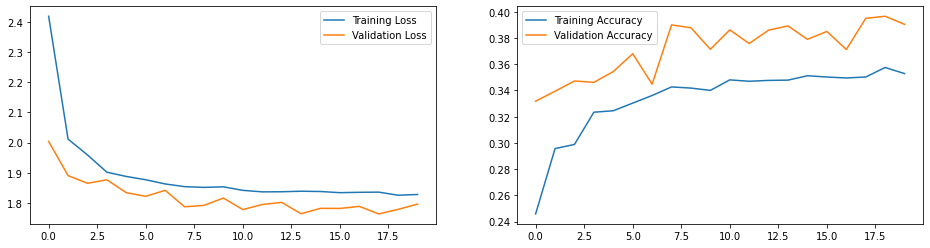

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time
0,DNN with 2 layers (no regularization),1.434201,0.491333,1.536505,0.4516,1.498227,0.4673,39.133910
1,DNN with 3 layers (no regularization),1.153715,0.588200,1.425242,0.5100,1.403160,0.5123,40.682541
2,CNN with 2 convolution/max pooling layers (no ...,0.058982,0.980289,2.110118,0.7116,2.168833,0.6988,142.778869
3,CNN with 3 convolution/max pooling layers (no ...,0.065756,0.976956,1.609691,0.7440,1.675821,0.7342,150.401488
4,DNN with 2 layers (with regularization),1.859747,0.341267,1.816639,0.3778,1.794182,0.3857,35.777248
5,DNN with 3 layers (with regularization),1.828189,0.352844,1.796530,0.3904,1.785738,0.3981,44.277207


In [33]:
model2_reg = models.Sequential()
model2_reg.add(layers.InputLayer(input_shape=(32, 32, 3)))
model2_reg.add(layers.Flatten(name ='flatten'))
model2_reg.add(layers.Dense(name = "hidden_layer",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model2_reg.add(layers.Dropout(0.3))
model2_reg.add(layers.Dense(name = "hidden_layer2",units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model2_reg.add(layers.Dropout(0.3))
model2_reg.add(layers.Dense(name = "output_layer",units=10, activation=tf.nn.softmax))

result2_reg = compile_train_model(model2_reg)

new_col = ['DNN with 3 layers (with regularization)']   
result2_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result2_reg, ignore_index = True)
assignment_result_table

Epoch 1/20
450/450 [==============================] - 8s 16ms/step - loss: 1.9747 - accuracy: 0.4990 - val_loss: 2.0034 - val_accuracy: 0.5698
Epoch 2/20
450/450 [==============================] - 7s 16ms/step - loss: 1.4081 - accuracy: 0.6327 - val_loss: 1.2978 - val_accuracy: 0.6610
Epoch 3/20
450/450 [==============================] - 7s 16ms/step - loss: 1.2775 - accuracy: 0.6816 - val_loss: 1.2932 - val_accuracy: 0.6876
Epoch 4/20
450/450 [==============================] - 7s 16ms/step - loss: 1.2297 - accuracy: 0.7133 - val_loss: 1.2237 - val_accuracy: 0.7202
Epoch 5/20
450/450 [==============================] - 7s 15ms/step - loss: 1.2047 - accuracy: 0.7351 - val_loss: 1.2685 - val_accuracy: 0.7142
Epoch 6/20
450/450 [==============================] - 7s 15ms/step - loss: 1.1903 - accuracy: 0.7472 - val_loss: 1.3466 - val_accuracy: 0.6968
Epoch 7/20
450/450 [==============================] - 7s 16ms/step - loss: 1.1740 - accuracy: 0.7630 - val_loss: 1.2985 - val_accuracy: 0.7206

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

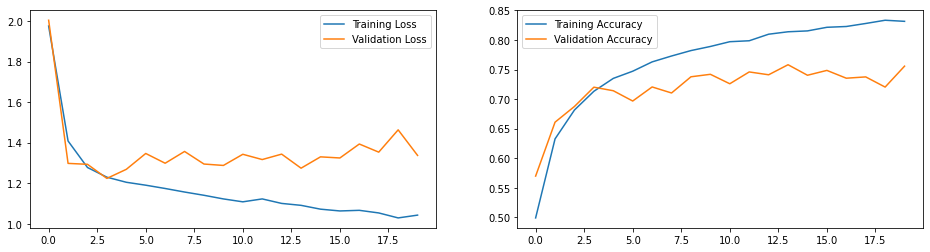

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time
0,DNN with 2 layers (no regularization),1.434201,0.491333,1.536505,0.4516,1.498227,0.4673,39.133910
1,DNN with 3 layers (no regularization),1.153715,0.588200,1.425242,0.5100,1.403160,0.5123,40.682541
2,CNN with 2 convolution/max pooling layers (no ...,0.058982,0.980289,2.110118,0.7116,2.168833,0.6988,142.778869
3,CNN with 3 convolution/max pooling layers (no ...,0.065756,0.976956,1.609691,0.7440,1.675821,0.7342,150.401488
4,DNN with 2 layers (with regularization),1.859747,0.341267,1.816639,0.3778,1.794182,0.3857,35.777248
5,DNN with 3 layers (with regularization),1.828189,0.352844,1.796530,0.3904,1.785738,0.3981,44.277207
6,CNN with 2 convolution/max pooling layers (wit...,1.042711,0.831622,1.337028,0.7558,1.349808,0.7570,148.239210


In [34]:
model3_reg = models.Sequential()
model3_reg.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model3_reg.add(layers.MaxPool2D((2, 2),strides=2))
model3_reg.add(layers.Dropout(0.3))
model3_reg.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model3_reg.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model3_reg.add(layers.Dropout(0.3))
model3_reg.add(layers.Flatten())
model3_reg.add(layers.BatchNormalization())
model3_reg.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model3_reg.add(layers.Dense(units=10, activation=tf.nn.softmax))

result3_reg = compile_train_model(model3_reg)

new_col = ['CNN with 2 convolution/max pooling layers (with regularization)']   
result3_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result3_reg, ignore_index = True)
assignment_result_table

Epoch 1/20
450/450 [==============================] - 9s 19ms/step - loss: 1.9538 - accuracy: 0.4404 - val_loss: 1.6356 - val_accuracy: 0.5296
Epoch 2/20
450/450 [==============================] - 8s 18ms/step - loss: 1.3597 - accuracy: 0.5870 - val_loss: 1.2290 - val_accuracy: 0.6098
Epoch 3/20
450/450 [==============================] - 8s 18ms/step - loss: 1.1474 - accuracy: 0.6463 - val_loss: 1.0148 - val_accuracy: 0.6944
Epoch 4/20
450/450 [==============================] - 8s 18ms/step - loss: 1.0459 - accuracy: 0.6799 - val_loss: 1.0367 - val_accuracy: 0.6796
Epoch 5/20
450/450 [==============================] - 8s 18ms/step - loss: 0.9826 - accuracy: 0.7009 - val_loss: 0.9217 - val_accuracy: 0.7222
Epoch 6/20
450/450 [==============================] - 8s 17ms/step - loss: 0.9485 - accuracy: 0.7196 - val_loss: 1.0717 - val_accuracy: 0.6870
Epoch 7/20
450/450 [==============================] - 8s 18ms/step - loss: 0.9210 - accuracy: 0.7277 - val_loss: 0.9811 - val_accuracy: 0.7092

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

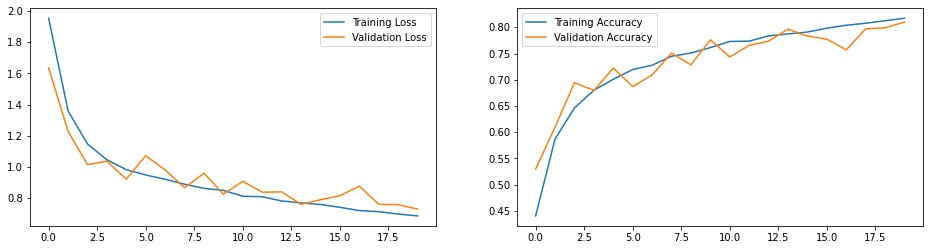

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time
0,DNN with 2 layers (no regularization),1.434201,0.491333,1.536505,0.4516,1.498227,0.4673,39.133910
1,DNN with 3 layers (no regularization),1.153715,0.588200,1.425242,0.5100,1.403160,0.5123,40.682541
2,CNN with 2 convolution/max pooling layers (no ...,0.058982,0.980289,2.110118,0.7116,2.168833,0.6988,142.778869
3,CNN with 3 convolution/max pooling layers (no ...,0.065756,0.976956,1.609691,0.7440,1.675821,0.7342,150.401488
4,DNN with 2 layers (with regularization),1.859747,0.341267,1.816639,0.3778,1.794182,0.3857,35.777248
5,DNN with 3 layers (with regularization),1.828189,0.352844,1.796530,0.3904,1.785738,0.3981,44.277207
6,CNN with 2 convolution/max pooling layers (wit...,1.042711,0.831622,1.337028,0.7558,1.349808,0.7570,148.239210
7,CNN with 3 convolution/max pooling layers (wit...,0.685927,0.817244,0.729838,0.8100,0.753827,0.7978,221.553470


In [35]:
model4_reg = models.Sequential()
model4_reg.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model4_reg.add(layers.MaxPool2D((2, 2),strides=2))
model4_reg.add(layers.Dropout(0.3))
model4_reg.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4_reg.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model4_reg.add(layers.Dropout(0.3))
model4_reg.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4_reg.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model4_reg.add(layers.Dropout(0.3))
model4_reg.add(layers.Flatten())
model4_reg.add(layers.BatchNormalization())
model4_reg.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model4_reg.add(layers.Dense(units=10, activation=tf.nn.softmax))

result4_reg = compile_train_model(model4_reg)

new_col = ['CNN with 3 convolution/max pooling layers (with regularization)']   
result4_reg.insert(loc=0, column='Model', value=new_col)
assignment_result_table = assignment_result_table.append(result4_reg, ignore_index = True)
assignment_result_table


(b) Create more experiments on your own by tweaking architectures and/or hyper parameters.

### Load HDF5 Model Format 

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [40]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/models/model_0.8100.h5')

In [41]:
preds = model.predict(x_test_norm)

In [42]:
preds.shape

(10000, 10)

### Predictions

In [43]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [44]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.22%,0.05%,0.25%,93.97%,0.17%,2.26%,0.17%,0.39%,2.45%,0.06%
1,1.83%,38.06%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,59.60%,0.51%
2,3.51%,1.97%,0.02%,0.03%,0.00%,0.00%,0.00%,0.01%,92.33%,2.13%
3,97.82%,0.10%,0.08%,0.10%,0.05%,0.01%,0.00%,0.05%,1.72%,0.07%
4,0.00%,0.00%,9.46%,0.46%,7.15%,0.04%,82.86%,0.00%,0.00%,0.00%
5,0.01%,0.05%,0.27%,0.88%,0.10%,0.50%,98.00%,0.00%,0.05%,0.14%
6,1.42%,80.69%,0.53%,1.50%,0.01%,1.44%,0.02%,0.07%,0.05%,14.27%
7,0.38%,0.01%,15.37%,3.51%,6.15%,1.05%,73.29%,0.07%,0.06%,0.12%
8,0.00%,0.00%,0.15%,96.40%,1.57%,1.37%,0.20%,0.30%,0.00%,0.00%
9,0.22%,64.28%,0.03%,0.04%,0.02%,0.01%,0.37%,0.00%,0.71%,34.32%


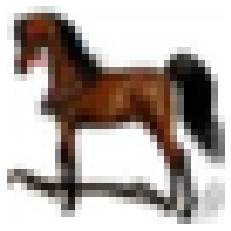

In [48]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [49]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [50]:
activations = activation_model.predict(img_tensor)
len(activations)

8

In [55]:
layer_names = []
for layer in model.layers[1:5]:
    layer_names.append(layer.name)
    
layer_names

['max_pooling2d_7', 'dropout_5', 'conv2d_8', 'max_pooling2d_8']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


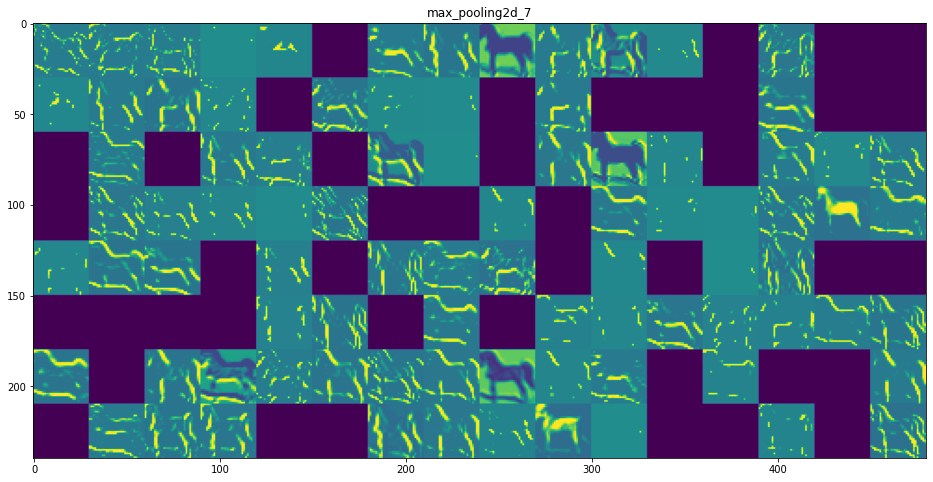

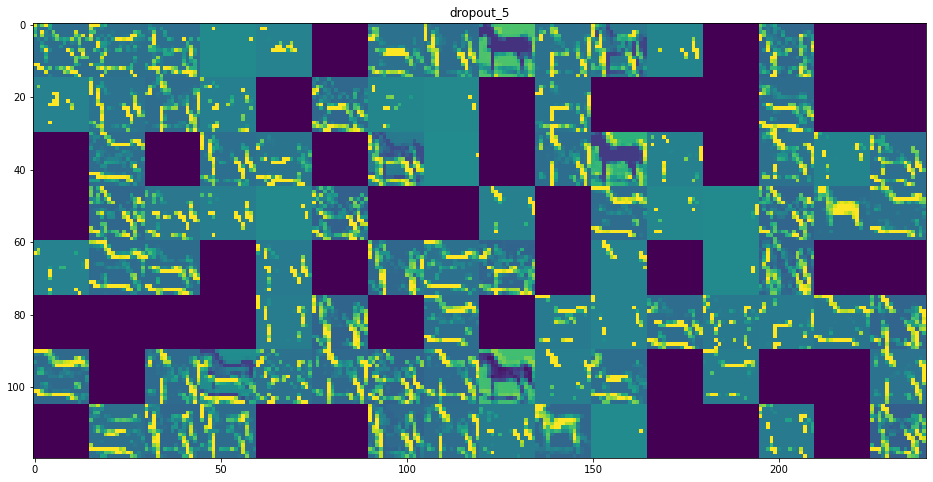

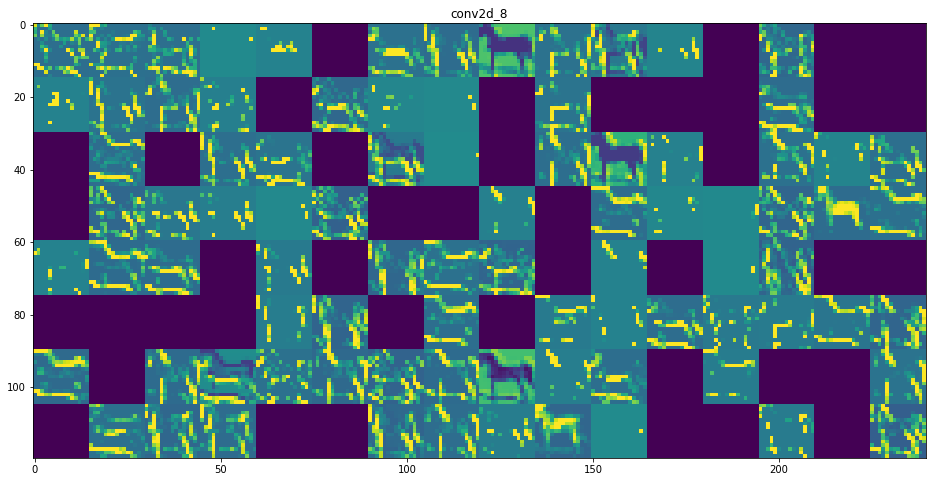

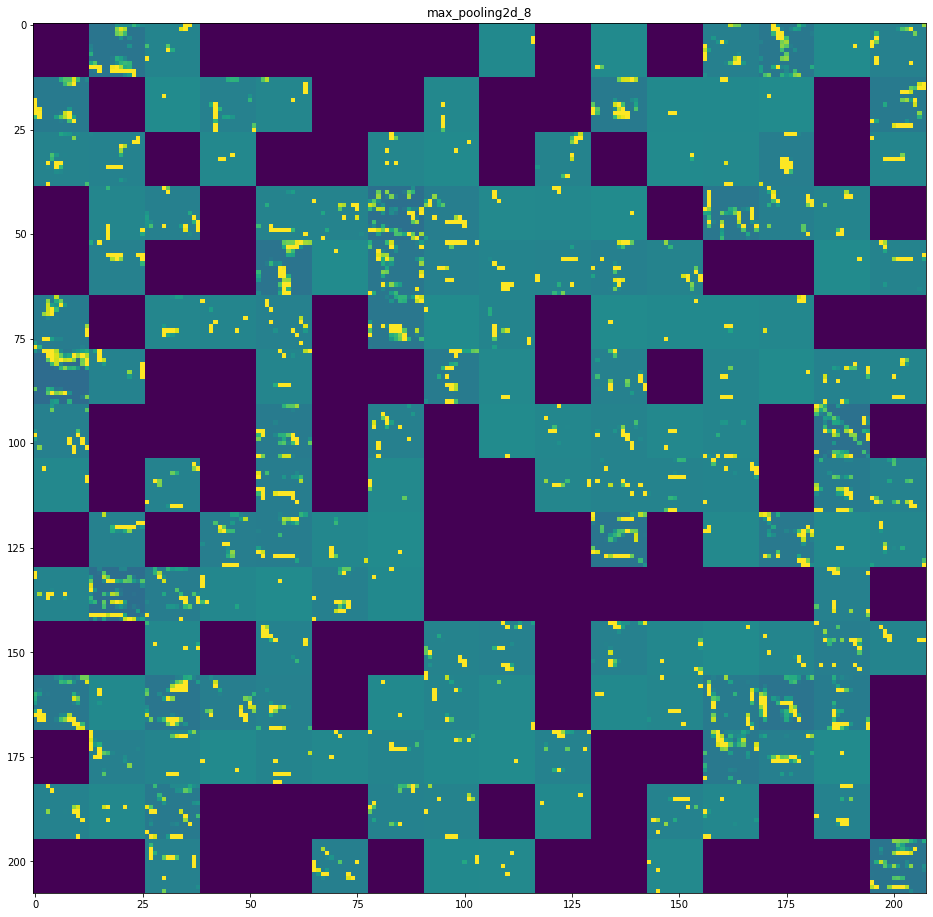

In [57]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[1:5]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();